# Import modules

In [ ]:
#import general modules
import numpy as np
import io, sys, time, math, os.path, unittest, sys
import matplotlib.pyplot as plt
import pandas as pd

# Load files

In [ ]:
#Todo: use sys commands to dynamically find in github folder
github_folder='/Users/mrubashkin/greenspace/'
file_location=github_folder+'raw_data/Dept_Interior_Data/'

file_name='NRRS_reservations_byVisitorOriginZip_AllYears.csv'
zip_origin_df=pd.read_csv(file_location+file_name)

file_name='NRRS_reservations_byFacilityName_AllYears.csv'
by_campground_df=pd.read_csv(file_location+file_name)

file_name='PPL_reservationdata.csv' #2.2gb --> very large
reservation_df=by_campground_df=pd.read_csv(file_location+file_name)


In [ ]:
#load models
github_folder='/Users/mrubashkin/greenspace/'
file_location=github_folder+'raw_data/'
file_name='ESRI_ZipCodes_wDistance2nearestFacility_km.txt'
distance_to_park_df=pd.read_csv(file_location+file_name)
#distance_to_park_df[['D2NF_km','ZIP_CODE']]

In [ ]:
#Census Data
file_location=github_folder+'raw_data/'

file_name='aggregate_income.csv'
income_df=pd.read_csv(file_location+file_name)

file_name='2010CensusPopulationData.csv'
racial_info_df=pd.read_csv(file_location+file_name)

#distance to 
file_name='ESRI_ZipCodes_wDistance2nearestFacility_km.txt'
distance_to_park_df=pd.read_csv(file_location+file_name)
distance_to_park_df[['D2NF_km','ZIP_CODE']]

file_name='education.csv'
education_df=pd.read_csv(file_location+file_name)
education_df.rename(columns={'zip code tabulation area': 'zip_code_tabulation_area'},inplace=True)
education_df.rename(columns={'B06009_001E': 'Total_reported_education_per_zip'},inplace=True)
education_df.rename(columns={'B06009_002E': 'Less_than_high_school_graduate'},inplace=True)
education_df.rename(columns={'B06009_003E': 'High_school_graduate'},inplace=True)
education_df.rename(columns={'B06009_004E': 'Some_college_or_associates_degree'},inplace=True)
education_df.rename(columns={'B06009_005E': 'Bachelor_degree'},inplace=True)
education_df.rename(columns={'B06009_006E': 'Graduate_or_professional_degree'},inplace=True)
education_df=education_df[['zip_code_tabulation_area','Less_than_high_school_graduate','High_school_graduate'
                ,'Some_college_or_associates_degree','Bachelor_degree','Graduate_or_professional_degree'
                ,'Total_reported_education_per_zip']]
#education_df

In [ ]:
#drop the duplicate columns and use to merge
temp=reservation_df.drop_duplicates(subset = ' CustZip')
temp=temp[[' CustState',' CustCountry',' CustZip']]
temp[' CustZip']=pd.to_numeric(temp[' CustZip'], errors='coerce')

# Join dataframes

In [ ]:
#join the dataframes
aggregate_df=pd.merge(zip_origin_df, racial_info_df, left_on = 'visitor_zip', right_on = 'Zip')
aggregate_df=pd.merge(aggregate_df,income_df,left_on='visitor_zip',right_on='zip code tabulation area')
#move the line below to higher up
aggregate_df.rename(columns={'Annual Aggregate Family Income': 'Annual_Aggregate_Family_Income'},inplace=True)
aggregate_df= pd.merge(aggregate_df,temp,left_on = 'visitor_zip', right_on = ' CustZip')
aggregate_df= pd.merge(aggregate_df,education_df,left_on='visitor_zip',right_on='zip_code_tabulation_area')
aggregate_df=pd.merge(aggregate_df,distance_to_park_df,left_on='visitor_zip',right_on='ZIP_CODE')

In [ ]:
#rename columns without spaces
aggregate_df.rename(columns={' CustZip': 'CustZip'},inplace=True)
aggregate_df.rename(columns={' CustState': 'CustState'},inplace=True)
aggregate_df.rename(columns={' CustCountry': 'Custcountry'},inplace=True)
#aggregate_df.iloc[0]['Custcountry']

# Create new columns

In [ ]:
#get the utilization_factors into the dataframe
aggregate_df['util_unique'] = pd.Series(
    (aggregate_df.sum_dur / aggregate_df.Population))
aggregate_df['util_days']= pd.Series(
    (aggregate_df.sum_persnight  / aggregate_df.Population))

In [ ]:
'''
TODO
make a unittest to make sure this is joined correctly
'''
print 'This %f should equal that %f'%\
    (float(aggregate_df.iloc[[0]]['sum_dur']\
    /float(aggregate_df.iloc[[0]]['Population'])),\
     float(aggregate_df.iloc[[0]]['util_unique']))

In [ ]:
#get the male/female breakdowns per visit per zip code
#using unique visits for the rest of these breakdowns!! (i.e. sum_dur)
aggregate_df['visits_female'] = pd.Series(
    ((aggregate_df.PopulationFemale / aggregate_df.Population)*aggregate_df.sum_dur))
aggregate_df['visits_male'] = pd.Series(
    ((aggregate_df.PopulationFemale / aggregate_df.Population)*aggregate_df.sum_dur))

In [ ]:
'''
TODO
make a unittest to make sure this is joined correctly
'''
print 'This %f should equal that %f'%\
    (float(aggregate_df.iloc[[0]]['PopulationFemale']\
    /float(aggregate_df.iloc[[0]]['Population']))\
    *float(aggregate_df.iloc[[0]]['sum_dur']),\
     float(aggregate_df.iloc[[0]]['visits_female']))

In [ ]:
#get the race breakdown per visit per zip code
aggregate_df['visits_RaceWhite'] = pd.Series(
    (aggregate_df.PopulationRaceWhite * aggregate_df.sum_dur))
aggregate_df['visits_RaceBlack'] = pd.Series(
    (aggregate_df.PopulationRaceBlack * aggregate_df.sum_dur))
aggregate_df['visits_Amerindian'] = pd.Series(
    (aggregate_df.PopulationAmerindian * aggregate_df.sum_dur))
aggregate_df['visits_RacePacific'] = pd.Series(
    (aggregate_df.PopulationRacePacific * aggregate_df.sum_dur))
aggregate_df['visits_RaceLatino'] = pd.Series(
    (aggregate_df.PopulationRaceLatino * aggregate_df.sum_dur))
aggregate_df['visits_RaceMulti'] = pd.Series(
    (aggregate_df.PopulationRaceMulti * aggregate_df.sum_dur))
aggregate_df['visits_RaceOther'] = pd.Series(
    (aggregate_df.PopulationRaceOther * aggregate_df.sum_dur))

In [ ]:
'''
TODO
make a unittest to make sure this is joined correctly
'''
print 'This %f should equal that %f'%\
    (float(aggregate_df.iloc[[0]]['PopulationRaceWhite']\
    *float(aggregate_df.iloc[[0]]['sum_dur'])),\
     float(aggregate_df.iloc[[0]]['visits_RaceWhite']))

In [ ]:
#scale the annual family aggregate income (which is per zip code)
#to individual families
aggregate_df['per_family_annual_income'] = pd.Series(
    (aggregate_df.Annual_Aggregate_Family_Income / aggregate_df.Households))

In [ ]:
print 'This %f should equal that %f'%\
    (float(aggregate_df.iloc[[0]]['Annual_Aggregate_Family_Income']\
    /float(aggregate_df.iloc[[0]]['Households'])),\
     float(aggregate_df.iloc[[0]]['per_family_annual_income']))


In [ ]:
#get percent of people who are high school educated
aggregate_df['non_hs_educated'] = pd.Series(
    (aggregate_df.Less_than_high_school_graduate / aggregate_df.Total_reported_education_per_zip))

In [ ]:
print 'This %f should equal that %f'%\
    (float(aggregate_df.iloc[[-1]]['Less_than_high_school_graduate']\
    /float(aggregate_df.iloc[[-1]]['Total_reported_education_per_zip'])),\
     float(aggregate_df.iloc[[-1]]['non_hs_educated']))

# Trim data

In [135]:
#create the data to send to Cartos DB and use for the graphing
regression_df=aggregate_df[[
        'CustZip',
        'CustState',
        'per_family_annual_income',
        'non_hs_educated',
        'PopulationRaceWhite',
        'D2NF_km',
        'util_days']]
#remove inf and NaN
regression_df=regression_df.replace([np.inf, -np.inf], np.nan).dropna()
#rename the distance column
regression_df.rename(columns={'D2NF_km': 'Dist_to_park'},inplace=True)
#print random entry
regression_df.iloc[81]

CustZip                          1238
CustState                          MA
per_family_annual_income      59572.3
non_hs_educated             0.0597802
PopulationRaceWhite           0.91963
Dist_to_park                  30.7341
util_days                   0.0764015
Name: 142, dtype: object

# Save the trimmed datframe to database

In [106]:
#save the dataframe to a csv
file_location=github_folder + 'processed_data/'
file_name='test4.csv'
regression_df.to_csv(file_location+file_name, sep=',')

# Linear Regression

In [ ]:
from sklearn import linear_model
clf = linear_model.LinearRegression()
clf.fit([[getattr(t, 'x%d' % i) for i in range(1, 8)] for t in texts],
        [t.y for t in texts])

In [140]:
print regression_df.columns

Index([u'CustZip', u'CustState', u'per_family_annual_income',
       u'non_hs_educated', u'PopulationRaceWhite', u'Dist_to_park',
       u'util_days'],
      dtype='object')


In [217]:
import statsmodels.api as sm

#remove potential ouliers
min_visitation_value=0.01
regression_df_editted = regression_df[regression_df.util_days > min_visitation_value]


y=regression_df_editted['util_days'].tolist()


x=[regression_df_editted['per_family_annual_income'].tolist(),
   regression_df_editted['non_hs_educated'].tolist(),
   regression_df_editted['PopulationRaceWhite'].tolist(),
   regression_df_editted['Dist_to_park'].tolist(),
   ]

#calculate the y-intercept guess
y_intercept_guess=regression_df_editted['util_days'].median()
y_intercept_guess=0

def reg_m(y, x, y_intercept_guess):
    y_intercepts = np.empty(len(x[0]))
    y_intercepts.fill(y_intercept_guess)
    X = sm.add_constant(np.column_stack((x[0], y_intercepts)))
    for ele in x[1:]:
        X = sm.add_constant(np.column_stack((ele, X)))
    results = sm.OLS(y, X).fit()
    return results

reg_m(y,x,y_intercept_guess)
print reg_m(y, x,y_intercept_guess).summary()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.241
Model:                            OLS   Adj. R-squared:                  0.241
Method:                 Least Squares   F-statistic:                     2363.
Date:                Sat, 23 Apr 2016   Prob (F-statistic):               0.00
Time:                        21:16:29   Log-Likelihood:                -57117.
No. Observations:               29698   AIC:                         1.142e+05
Df Residuals:                   29694   BIC:                         1.143e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1            -0.0059      0.000    -36.968      0.0

In [188]:
x=[regression_df_editted['per_family_annual_income'].tolist(),
   regression_df_editted['non_hs_educated'].tolist(),
   regression_df_editted['PopulationRaceWhite'].tolist(),
   regression_df_editted['Dist_to_park'].tolist(),

0.290282299518


In [180]:
50000*0.007

350.0

In [177]:
y = [1,2,3,4,5,6,7,8,9,8,10,11]

x = [
     [4,8,12,15,20,24,28,31,36,42,44,48],
     ]

def reg_m(y, x):
    ones = np.ones(len(x[0]))
    X = sm.add_constant(np.column_stack((x[0], ones)))
    for ele in x[1:]:
        X = sm.add_constant(np.column_stack((ele, X)))
    results = sm.OLS(y, X).fit()
    return results

reg_m(y,x)
print reg_m(y, x).summary()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.963
Model:                            OLS   Adj. R-squared:                  0.959
Method:                 Least Squares   F-statistic:                     259.0
Date:                Sat, 23 Apr 2016   Prob (F-statistic):           1.77e-08
Time:                        20:35:41   Log-Likelihood:                -10.764
No. Observations:                  12   AIC:                             25.53
Df Residuals:                      10   BIC:                             26.50
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1             0.2154      0.013     16.095      0.0

# Test of association between income and education

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.171
Model:                            OLS   Adj. R-squared:                  0.171
Method:                 Least Squares   F-statistic:                     6139.
Date:                Sat, 23 Apr 2016   Prob (F-statistic):               0.00
Time:                        20:24:49   Log-Likelihood:            -3.4259e+05
No. Observations:               29698   AIC:                         6.852e+05
Df Residuals:                   29696   BIC:                         6.852e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1         -1.164e+05   1484.992    -78.355      0.0

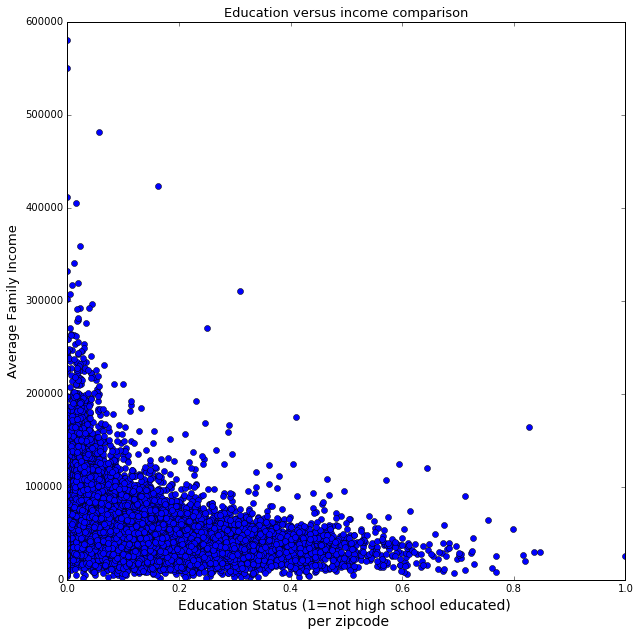

In [168]:
y=regression_df_editted['per_family_annual_income'].tolist()
x=[regression_df_editted['non_hs_educated'].tolist()]

def reg_m(y, x):
    ones = np.ones(len(x[0]))
    X = sm.add_constant(np.column_stack((x[0], ones)))
    for ele in x[1:]:
        X = sm.add_constant(np.column_stack((ele, X)))
    results = sm.OLS(y, X).fit()
    return results

reg_m(y,x)
print reg_m(y, x).summary()
plt.figure(figsize=(10,10))
plt.plot(regression_df_editted['non_hs_educated'].tolist(),regression_df_editted['per_family_annual_income'].tolist(),'bo')
plt.xlabel('Education Status (1=not high school educated) \n per zipcode',size=14)
plt.ylabel('Average Family Income', size=13)
plt.title('Education versus income comparison', size=13)

# Plot correlations

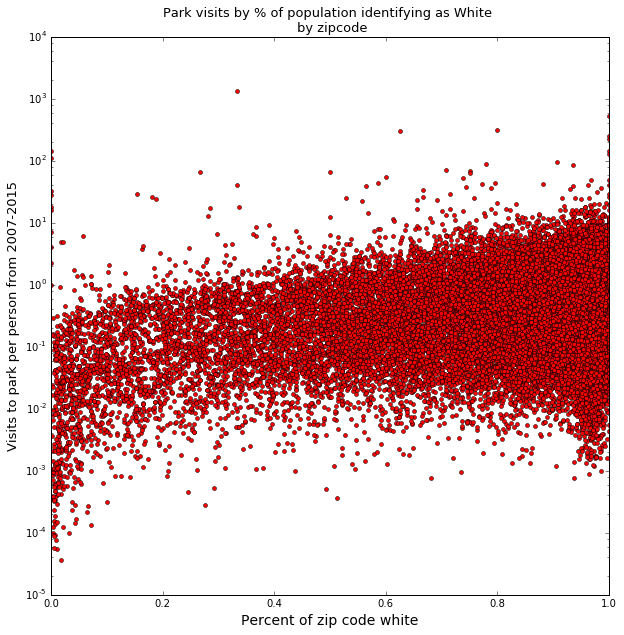

In [60]:
%matplotlib inline
plt.figure(figsize=(10,10))
plt.semilogy(regression_df['PopulationRaceWhite'],regression_df['util_days'],'ro',markersize = 4)
plt.xlabel('Percent of zip code white',size=14)
plt.ylabel('Visits to park per person from 2007-2015', size=13)
plt.title('Park visits by % of population identifying as White \n by zipcode', size=13)

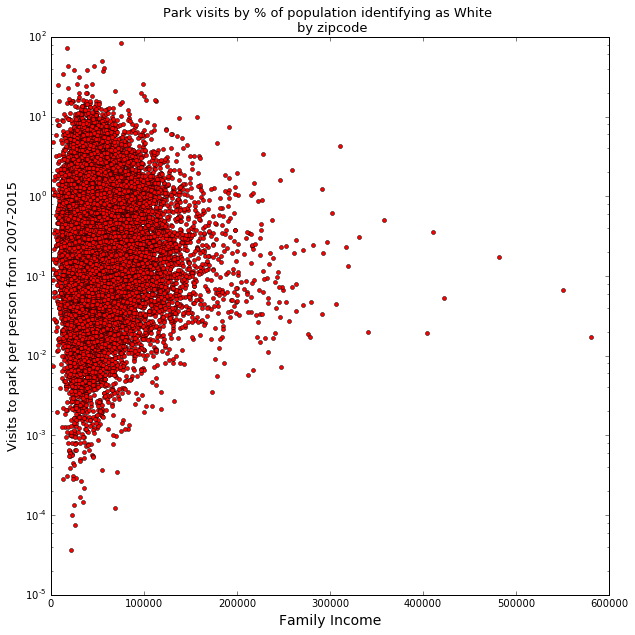

In [211]:
%matplotlib inline
plt.figure(figsize=(10,10))
plt.semilogy(regression_df['per_family_annual_income'],\
             regression_df['util_days'],'ro',markersize = 4)
plt.xlabel('Family Income',size=14)
plt.ylabel('Visits to park per person from 2007-2015', size=13)
plt.title('Park visits by % of population identifying as White \n by zipcode', size=13)

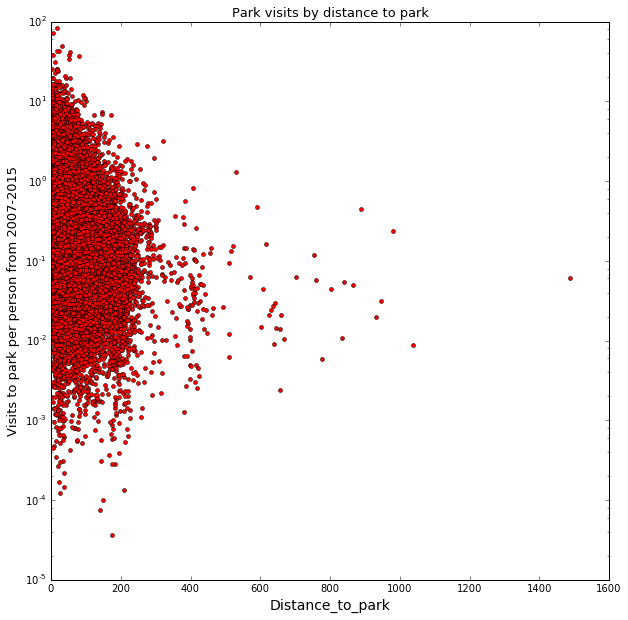

In [212]:
%matplotlib inline
plt.figure(figsize=(10,10))
plt.semilogy(regression_df['Dist_to_park'],\
             regression_df['util_days'],'ro',markersize = 4)
plt.xlabel('Distance_to_park',size=14)
plt.ylabel('Visits to park per person from 2007-2015', size=13)
plt.title('Park visits by distance to park', size=13)

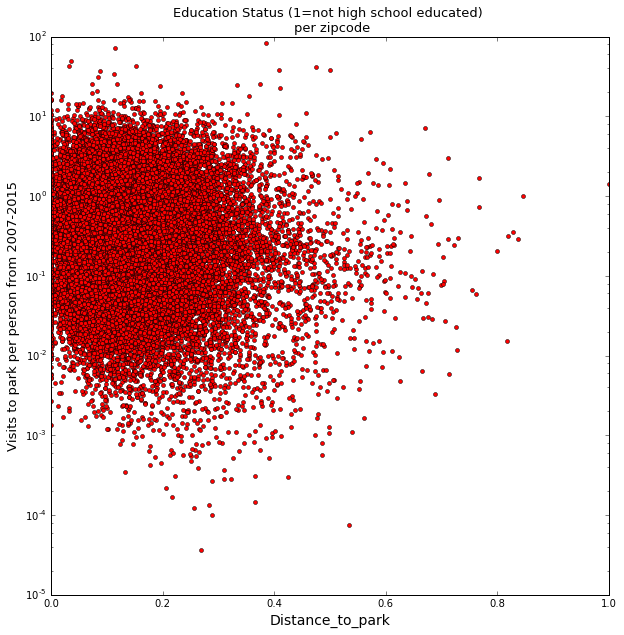

In [213]:
%matplotlib inline
plt.figure(figsize=(10,10))
plt.semilogy(regression_df['non_hs_educated'],\
             regression_df['util_days'],'ro',markersize = 4)
plt.xlabel('Distance_to_park',size=14)
plt.ylabel('Visits to park per person from 2007-2015', size=13)
plt.title('Education Status (1=not high school educated) \n per zipcode', size=13)